Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# OCTA-500 3D segmentation 
## (adapted from [MONAI 3D Spleen CT seg tutorial](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb))

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

## OCTA-500 Dataset

The OCTA-500 dataset can be downloaded from https://ieee-dataport.org/open-access/octa-500.

**By using the OCTA-500 dataset, you are obliged to reference at least one of the following papers:**

- Mingchao Li, Kun Huang, Qiuzhuo Xu, Jiadong Yang, Yuhan Zhang, Zexuan Ji, Keren Xie, Songtao Yuan, Qinghuai Liu, and Qiang Chen. "OCTA-500: A Retinal Dataset for Optical Coherence Tomography Angiography Study," Medical Image Analysis, 2024: 103092.
- Mingchao Li, Yerui Chen, Zexuan Ji, Keren Xie, Songtao Yuan, Qiang Chen, and Shuo Li."Image projection network: 3D to 2D image segmentation in OCTA images," IEEE Trans. Med. Imaging, vol.39, no.11, pp.3343-3354, 2020.

![octa-500](https://ieee-dataport.org/sites/default/files/styles/large/public/Fig1-01.png?itok=KDN2gnkw)

Target: Spleen  
Modality: OCT/OCTA
Size: 200 3D volumes (130 Training + 20 Validation + 50 Testing), 3x3x2mm FOV @ 304x304x640
Challenge: OCT modality, thin layers to segment, dual-channel volumes (OCT/OCTA), multi-target

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [39]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, DynUNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from pprint import pprint

print_config()

MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.0
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

NameError: name 'root_dir' is not defined

## Set OCTA-500 dataset path

In [8]:
basepath = os.path.normpath(
    os.path.join(os.getcwd(), "..", "datasets/OCTA-500/OCTA500_MONAI_3mm")
)
paths = sorted(os.listdir(basepath))
paths = [path for path in paths if path != '.ipynb_checkpoints']

In [9]:
all_samples = []
for path in paths:
    all_samples.append(
        {
            "vol_OCT": os.path.join(basepath, path, "vol_OCT.nii.gz"),
            "vol_OCTA": os.path.join(basepath, path, "vol_OCTA.nii.gz"),
            "label_3D_FAZ": os.path.join(basepath, path, "label_3D_FAZ.nii.gz"),
            "label_3D_Layers": os.path.join(basepath, path, "label_3D_Layers.nii.gz"),
        }
    )

train_files = all_samples[:130]
val_files = all_samples[130:150]
test_files = all_samples[150:]
print("\nExample sample from training set:")
pprint(train_files[0])
print("\n")
for tag in ["vol_OCT", "vol_OCTA", "label_3D_FAZ", "label_3D_Layers"]:
    print(f"Found all '{tag}': {np.all([os.path.exists(sample['vol_OCT']) for sample in all_samples])}")


Example sample from training set:
{'label_3D_FAZ': '/workspace/Projects/datasets/OCTA-500/OCTA500_MONAI_3mm/10301/label_3D_FAZ.nii.gz',
 'label_3D_Layers': '/workspace/Projects/datasets/OCTA-500/OCTA500_MONAI_3mm/10301/label_3D_Layers.nii.gz',
 'vol_OCT': '/workspace/Projects/datasets/OCTA-500/OCTA500_MONAI_3mm/10301/vol_OCT.nii.gz',
 'vol_OCTA': '/workspace/Projects/datasets/OCTA-500/OCTA500_MONAI_3mm/10301/vol_OCTA.nii.gz'}


Found all 'vol_OCT': True
Found all 'vol_OCTA': True
Found all 'label_3D_FAZ': True
Found all 'label_3D_Layers': True


In [10]:
np.all([os.path.exists(sample["vol_OCT"]) for sample in all_samples])

True

## Set deterministic training for reproducibility

In [11]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [53]:
original_res = np.array([0.00986842, 0.00986842, 0.003125])
res_factor = [0.8, 0.8, 0.5] # half resolution
target_res = original_res/res_factor
new_size = (np.array([304, 304, 640])*res_factor).astype(int)
print(f"Original image res is: {original_res}")
print(f"New image res is: {target_res}")
print(f"New image size is: {new_size}")

Original image res is: [0.00986842 0.00986842 0.003125  ]
New image res is: [0.01233552 0.01233552 0.00625   ]
New image size is: [243 243 320]


In [34]:

train_transforms = Compose(
    [
        #LoadImaged(keys=["image", "label"]),
        LoadImaged(keys=["vol_OCT", "label_3D_Layers"]),
        EnsureChannelFirstd(keys=["vol_OCT", "label_3D_Layers"]),
        ScaleIntensityRanged(
            keys=["vol_OCT"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["vol_OCT", "label_3D_Layers"], axcodes="RAS"),
        Spacingd(
            keys=["vol_OCT", "label_3D_Layers"], 
            pixdim=(target_res[0], target_res[1], target_res[2]), 
            mode=("bilinear", "nearest")
        ),
        RandCropByPosNegLabeld(
            keys=["vol_OCT", "label_3D_Layers"],
            label_key="label_3D_Layers",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="vol_OCT",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["vol_OCT", "label_3D_Layers"]),
        EnsureChannelFirstd(keys=["vol_OCT", "label_3D_Layers"]),
        ScaleIntensityRanged(
            keys=["vol_OCT"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["vol_OCT", "label_3D_Layers"], axcodes="RAS"),
        Spacingd(
            keys=["vol_OCT", "label_3D_Layers"], 
            pixdim=(target_res[0], target_res[1], target_res[2]), 
            mode=("bilinear", "nearest")
        ),
    ]
)

## Check transforms in DataLoader

image shape: torch.Size([243, 243, 321]), label shape: torch.Size([243, 243, 321])


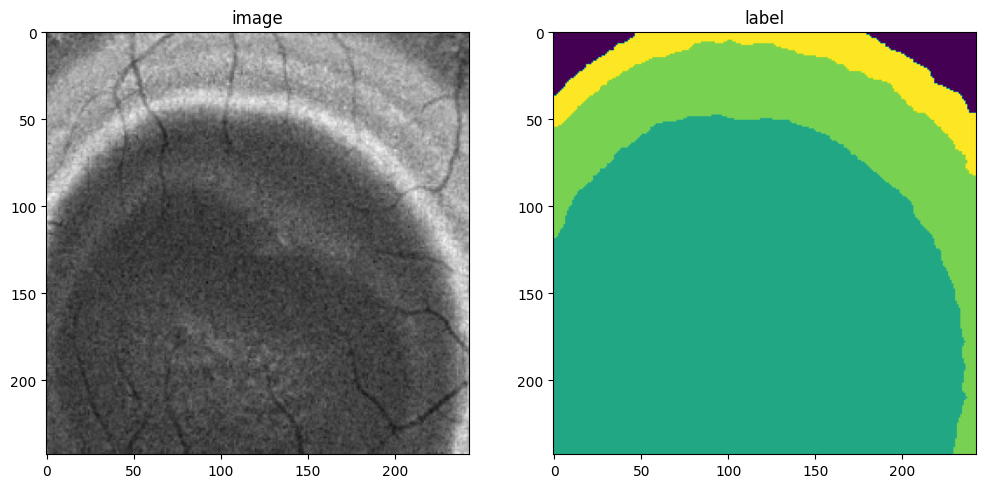

In [36]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["vol_OCT"][0][0], check_data["label_3D_Layers"][0][0]) 
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the middle slice [:, :, 160]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 160], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 160])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [37]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


## Create Model, Loss, Optimizer

In [51]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")

#model = UNet(
#    spatial_dims=3,
#    in_channels=1,
#    out_channels=2,
#    channels=(16, 32, 64, 128, 256),
#    strides=(2, 2, 2, 2),
#    num_res_units=2,
#    norm=Norm.BATCH,
#).to(device)

model = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=6,
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=(1, 2, 2, 2, 2, 2),
    upsample_kernel_size=[2, 2, 2, 2, 2, 2],
    dropout=0.2,
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [52]:
max_epochs = 2
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["vol_OCT"].to(device),
            batch_data["label_3D_Layers"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["vol_OCT"].to(device),
                    val_data["label_3D_Layers"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels, ignore_empty=True)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2
1/65, train_loss: 0.9181
2/65, train_loss: 0.9180
3/65, train_loss: 0.9144
4/65, train_loss: 0.8625
5/65, train_loss: 0.9140
6/65, train_loss: 0.8554
7/65, train_loss: 0.8540
8/65, train_loss: 0.8538
9/65, train_loss: 0.8544
10/65, train_loss: 0.9032
11/65, train_loss: 0.9014
12/65, train_loss: 0.9559
13/65, train_loss: 0.8876
14/65, train_loss: 0.8782
15/65, train_loss: 0.8233
16/65, train_loss: 0.9227
17/65, train_loss: 0.8894
18/65, train_loss: 0.8095
19/65, train_loss: 0.8769
20/65, train_loss: 0.7945
21/65, train_loss: 0.7861
22/65, train_loss: 0.7836
23/65, train_loss: 0.7856
24/65, train_loss: 0.8571
25/65, train_loss: 0.8474
26/65, train_loss: 0.8568
27/65, train_loss: 0.8306
28/65, train_loss: 0.8289
29/65, train_loss: 0.8110
30/65, train_loss: 0.7455
31/65, train_loss: 0.7256
32/65, train_loss: 0.8270
33/65, train_loss: 0.7213
34/65, train_loss: 0.7953
35/65, train_loss: 0.7241
36/65, train_loss: 0.6986
37/65, train_loss: 0.7200
38/65, train_loss: 0.6893


/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [386,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [358,0,0], thread: [36,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [317,0,0], thread: [32,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [196,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [196,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9510 at epoch: 598


## Plot the loss and metric

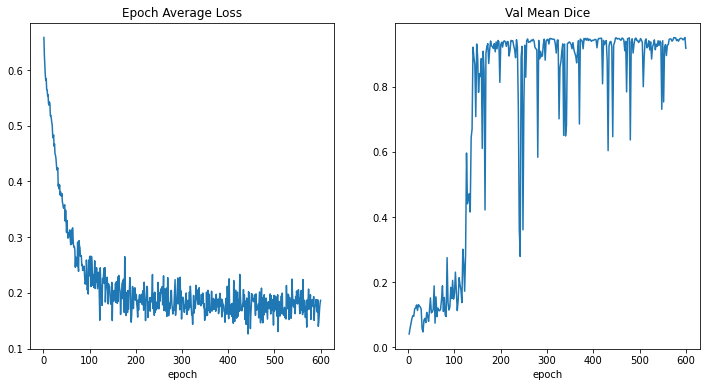

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

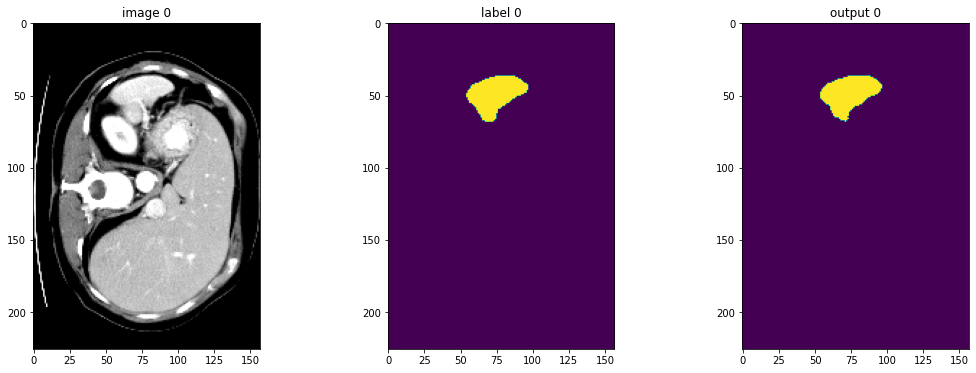

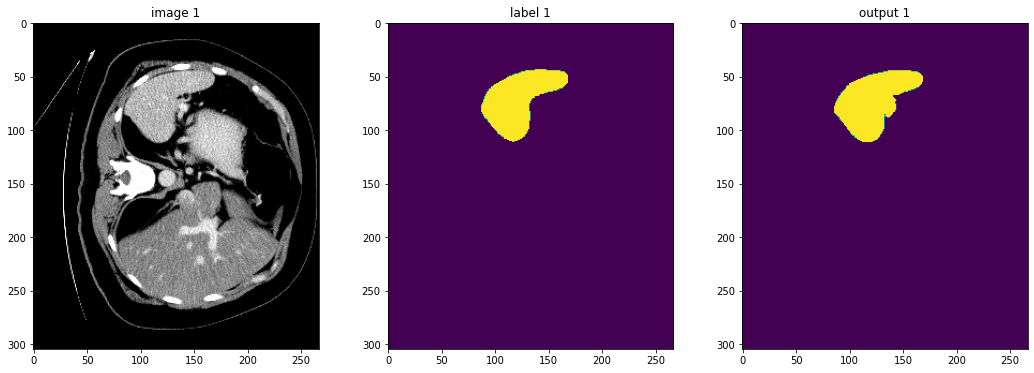

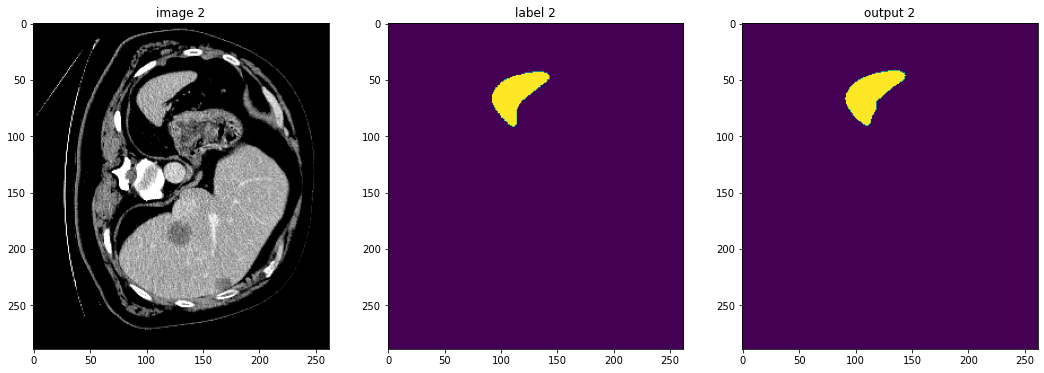

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [12]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [16]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9637420177459717


## Inference on Test Set

In [ ]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_output[0].meta["filename_or_obj"])

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 20], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)